# <center> Линейная регрессия 2: Ridge, Lasso и Elasticnet</center>

![](https://64.media.tumblr.com/72ca42a775d24a7f1c3c914b967fcd75/tumblr_pdqcnftNaV1w67ki0o2_500.gifv)

В этот раз мы поговорим про регуляризацию - метод добавления дополнительных ограничений к условию задачи с целью предотвратить переобучение или скорректировать ее неправильную постановку. Чаще всего, эта информация имеет вид штрафа за сложность модели. Если вы выбрали сложную модель, и при этом у вас недостаточно данных, то легко можно получить итоговую модель, которая хорошо описывает обучающую выборку, но не обобщается на тестовую.


# Начнем с повторения

В прошлых сериях мы познакомились с линейной регрессией. Давайте повторим основы и еще раз рассмотрим наш датасет, но с немного другой стороны.


In [1]:
import pandas as pd
import numpy as np

# ok, here we go again
data = pd.read_csv('Advertising.csv', index_col=0)
data.head()

,TV,Radio,Newspaper,Sales
1,230.1,37.8,69.2,22.1
2,44.5,39.3,45.1,10.4
3,17.2,45.9,69.3,9.3
4,151.5,41.3,58.5,18.5
5,180.8,10.8,58.4,12.9


## Множественная линейная регрессия


$y = \beta_0 + \beta_1x_1 + ... + \beta_nx_n$

Каждый $x$ представляет собой отдельный признак и имеет свой собственный коэффициент. В этом случае:

$y = \beta_0 + \beta_1 \times TV + \beta_2 \times Radio + \beta_3 \times Newspaper$


### Оценка ("обучение") коэффициентов модели


Вообще говоря, коэффициенты оцениваются с использованием **критерия наименьших квадратов**, что означает, что мы находим линию (математически), которая минимизирует **сумму квадратов остатков** (или «сумму квадратов ошибок»):

<img src="images/08_estimating_coefficients.png">

Что изображено на схеме?
- Черные точки - это **наблюдаемые значения** x и y.
- Синяя линия - это наша **линия полученная при минимизации квадратов ошибок**.
- Красные линии - это **остатки**, которые представляют собой расстояния между наблюдаемыми значениями и линией наименьших квадратов.

Как коэффициенты модели соотносятся с линией наименьших квадратов?
- $ \ beta_0 $ - это **точка пересечения** (значение $ y $, когда $ x $ = 0)
- $ \ beta_1 $ - это **наклон** (изменение $ y $, деленное на изменение $ x $)

Вот графическое изображение этих вычислений:

<img src="images/08_slope_intercept.png">

## В этот раз все по-взрослому, нам нужна выборка для тестировния

In [2]:
from sklearn.model_selection import train_test_split

train_data, test_data = train_test_split(data, test_size=0.5, random_state=67)

In [3]:
print(train_data.shape)
train_data.head()

(100, 4)


,TV,Radio,Newspaper,Sales
186,205.0,45.1,19.6,22.6
6,8.7,48.9,75.0,7.2
84,68.4,44.5,35.6,13.6
83,75.3,20.3,32.5,11.3
104,187.9,17.2,17.9,14.7


In [4]:
print(test_data.shape)
test_data.head()

(100, 4)


,TV,Radio,Newspaper,Sales
33,97.2,1.5,30.0,9.6
78,120.5,28.5,14.2,14.2
72,109.8,14.3,31.7,12.4
167,17.9,37.6,21.6,8.0
188,191.1,28.7,18.2,17.3


Нам нужно явно выделить наши признаки и таргет обучения. Давайте напишем несложную функцию и будем ее использовать:

In [5]:
def get_features_and_taget(data, column):
    return data.drop([column], axis=1).to_numpy(), data[column].to_numpy()

In [6]:
X_train, Y_train = get_features_and_taget(train_data, "Sales")
X_test, Y_test = get_features_and_taget(test_data, "Sales")

In [7]:
X_train[:10]

array([[205. ,  45.1,  19.6],
       [  8.7,  48.9,  75. ],
       [ 68.4,  44.5,  35.6],
       [ 75.3,  20.3,  32.5],
       [187.9,  17.2,  17.9],
       [ 66.9,  11.7,  36.8],
       [ 85.7,  35.8,  49.3],
       [170.2,   7.8,  35.2],
       [220.3,  49. ,   3.2],
       [180.8,  10.8,  58.4]])

In [8]:
Y_train[:10]

array([22.6,  7.2, 13.6, 11.3, 14.7,  9.7, 13.3, 11.7, 24.7, 12.9])

Обучим линейную регрессию с помощью sklearn:

In [9]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(X_train, Y_train)

LinearRegression()

Посмотрим на ее качество:

In [10]:
Y_train_prediced = model.predict(X_train)
Y_test_prediced = model.predict(X_test)

from sklearn.metrics import r2_score

print("Train R-squared Correlation", r2_score(Y_train_prediced, Y_train))
print("Test R-squared Correlation", r2_score(Y_test_prediced, Y_test))

Train R-squared Correlation 0.9059254619738741
Test R-squared Correlation 0.8565565111381532


А теперь, как настоящие машинлернеры, давайте напишем фичи.

Часто, чтобы выша модель могла давать лучшие прогнозы, вам нужно добавить больше фичей, которые могли бы учесть некоторые зависимости в ваших данных. Например, добавив квадрат переменной TV, мы сможем учесть часть нелинейной зависимости:

In [11]:
data = pd.read_csv('Advertising.csv', index_col=0)

data["TV_2"] = np.power(data["TV"], 2)

train_data, test_data = train_test_split(data, test_size=0.5, random_state=67)


X_train, Y_train = get_features_and_taget(train_data, "Sales")
X_test, Y_test = get_features_and_taget(test_data, "Sales")

model = LinearRegression()
model.fit(X_train, Y_train)


Y_train_prediced = model.predict(X_train)
Y_test_prediced = model.predict(X_test)

print("Train R-squared Correlation", r2_score(Y_train_prediced, Y_train))
print("Test R-squared Correlation", r2_score(Y_test_prediced, Y_test))

Train R-squared Correlation 0.9245602310435505
Test R-squared Correlation 0.8910415134867762


Кажется, стало лучше. Так чего мелочиться, давайте напишем много фичей в цикле:

In [12]:
data = pd.read_csv('Advertising.csv', index_col=0)

from sklearn.preprocessing import scale

for i in range(3, 10):
    # we use scale to avoid numerical problems. Use values less then 20
    data[f"TV_{i}"] = np.power(scale(data["TV"]), i)
    data[f"Radio_{i}"] = np.power(scale(data["Radio"]), i)
    data[f"Newspaper_{i}"] = np.power(scale(data["Newspaper"]), i)
    
data

,TV,Radio,Newspaper,Sales,TV_3,Radio_3,Newspaper_3,TV_4,Radio_4,Newspaper_4,...,Newspaper_6,TV_7,Radio_7,Newspaper_7,TV_8,Radio_8,Newspaper_8,TV_9,Radio_9,Newspaper_9
1,230.1,37.8,69.2,22.1,0.912256,0.945585,5.629734,0.884754,0.928113,10.014990,...,31.693909,8.071218e-01,0.877610,56.381736,7.827889e-01,0.861394,100.300034,7.591896e-01,0.845478,178.428291
2,44.5,39.3,45.1,10.4,-1.716690,1.269563,0.300196,2.055524,1.374692,0.201005,...,0.090118,-3.528697e+00,1.745258,0.060341,4.225178e+00,1.889779,0.040403,-5.059128e+00,2.046268,0.027053
3,17.2,45.9,69.3,9.3,-3.485225,3.570796,5.673550,5.284141,5.457831,10.119052,...,32.189169,-1.841642e+01,19.488801,57.410948,2.792215e+01,29.787918,102.395219,-4.233430e+01,45.529739,182.626854
4,151.5,41.3,58.5,18.5,0.000141,1.806287,2.128792,0.000007,2.199795,2.738489,...,4.531755,1.034967e-09,3.973461,5.829673,5.386971e-11,4.839099,7.499321,2.803901e-12,5.893320,9.647164
5,180.8,10.8,58.4,12.9,0.061248,-0.596126,2.106021,0.024143,0.501708,2.699502,...,4.435325,1.478697e-03,-0.299081,5.685208,5.828758e-04,0.251711,7.287310,2.297593e-04,-0.211843,9.340887
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
196,38.2,3.7,13.8,7.6,-2.052937,-2.305361,-0.458701,2.609161,3.045453,0.353758,...,0.210407,-5.356445e+00,-7.020870,-0.162269,6.807724e+00,9.274786,0.125145,-8.652212e+00,-12.252279,-0.096514
197,94.2,4.9,8.1,9.7,-0.234926,-1.906636,-1.104219,0.144957,2.364234,1.141319,...,1.219301,-3.405419e-02,-4.507734,-1.260267,2.101264e-02,5.589603,1.302610,-1.296554e-02,-6.931122,-1.346376
198,177.0,9.3,6.4,12.8,0.042805,-0.838292,-1.374490,0.014974,0.790425,1.528230,...,1.889222,6.409529e-04,-0.662607,-2.100536,2.242118e-04,0.624772,2.335486,7.843153e-05,-0.589097,-2.596715
199,283.6,42.0,66.2,25.5,4.054403,2.024868,4.417806,6.465009,2.561703,7.248958,...,19.517012,2.621175e+01,5.187110,32.024490,4.179634e+01,6.562324,52.547385,6.664700e+01,8.302137,86.222378


In [13]:
train_data, test_data = train_test_split(data, test_size=0.5, random_state=67)


X_train, Y_train = get_features_and_taget(train_data, "Sales")
X_test, Y_test = get_features_and_taget(test_data, "Sales")

model = LinearRegression()
model.fit(X_train, Y_train)


Y_train_prediced = model.predict(X_train)
Y_test_prediced = model.predict(X_test)

print("Train R-squared Correlation", r2_score(Y_train_prediced, Y_train))
print("Test R-squared Correlation", r2_score(Y_test_prediced, Y_test))

Train R-squared Correlation 0.9480301794050342
Test R-squared Correlation 0.8019777848244662


Как можно видеть, качество модели ($R^2$) падает на тесте, а на трейне растет. Это называется **переобучение**

![](https://miro.medium.com/max/875/1*_7OPgojau8hkiPUiHoGK_w.png)

**Optional**: Засуньте все выше в цикл и нарисуйте (import matplotlib.pyplot as plt) линии для трейна и теста с разными уровнями степени, а мы идем дальше. 

### Материал для отличников труда (optional)

Здесь стоит упомянуть про баланс между смещением и отклонением (переобучение и недообучение модели). Чтобы понять, что это, рассмотрим следующие определения и изображения ниже:

* **Bias** (смещение) - это систематическая ошибка прогноза. Ключевым словом является **систематическая** ошибка (в наклоне **k**), а не локальная ошибка (остатки **y**). Вы можете думать о **bias** как о точности прогнозов, по сути, это матожидание разности между истинным ответом и выданным алгоритмом.
* **Variance** (разброс) - мера разброса нашего вектора весов оценок.

Таким образом, разброс характеризует разнообразие алгоритмов (из-за случайности обучающей выборки, в том числе шума, и стохастической природы настройки), а смещение – способность модели алгоритмов настраиваться на целевую зависимость. 


![](https://alexanderdyakonov.files.wordpress.com/2018/04/bv_all.jpg)
![](http://www.ebc.cat/wp-content/uploads/2017/02/right_fited_model-1024x623.png)

# Теперь вообще серьезно. Ну, практически

Воспользуемся набором данных с признаками по недвижимости для предсказания ее стоимости с Kaggle: [House Prices: Advanced Regression Techniques](https://www.kaggle.com/c/house-prices-advanced-regression-techniques). Данные заранее разделены на обучающую (train) и тестовую (test) выборки. 

На самом деле, выше, когда мы говорили про трейн и тест, мы немного упрощали картину мира. Вообще говоря, тест, обычно, - это наша с вами жизнь, а в случае соревнования он нам просто недоступен. Также, правильнее выделять 3 типа выборок: тренировочную, валидационную и тестовую.

In [14]:
import warnings
warnings.filterwarnings('ignore')

train = pd.read_csv('./data/train.csv', index_col=0)
test = pd.read_csv('./data/test.csv', index_col=0)
print(f'Размер train: {train.shape}')
print(f'Размер test: {test.shape}')

Размер train: (1460, 80)
Размер test: (1459, 79)


В test количество колонок меньше на 1:

In [15]:
set(list(train.columns)) - set(list(test.columns))

{'SalePrice'}

Так как в данном случае таргет мы имеем только для трейна, работать будем только с ним. Если хотите закомитить решение на Kaggle, проделайте те же самые операции с тестом. 

SalePrice - наша таргетная (целевая) переменная. Полное описание всех 79 признаков в данных доступно в файле ```data_description.txt``` либо можно посмотреть на [Kaggle](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data)

## Работа с данными

### Чтобы улучшить качествоваших прогнозов можно немного пошаманить (optional):

1. Найти и удалить выбросы
2. Заполнить пропущенные значения
3. Придумать фичи

### 1. Удаляем выбросы

Покажем этот шаг на примере с одним признаком - жилой площадью. То же самое можно проделать по остальным признакам.   

Значение z-score +/- 3 обычно рассматривается как выброс. Ну, или на глаз :)

In [16]:
train.shape[0]

1460

In [17]:
from scipy import stats

z_scores = stats.zscore(train['GrLivArea'])
train['z_score'] = np.abs(z_scores)
print('Было 1460, осталось', train[train.z_score < 3].shape[0], 'наблюдения')

Было 1460, осталось 1444 наблюдения


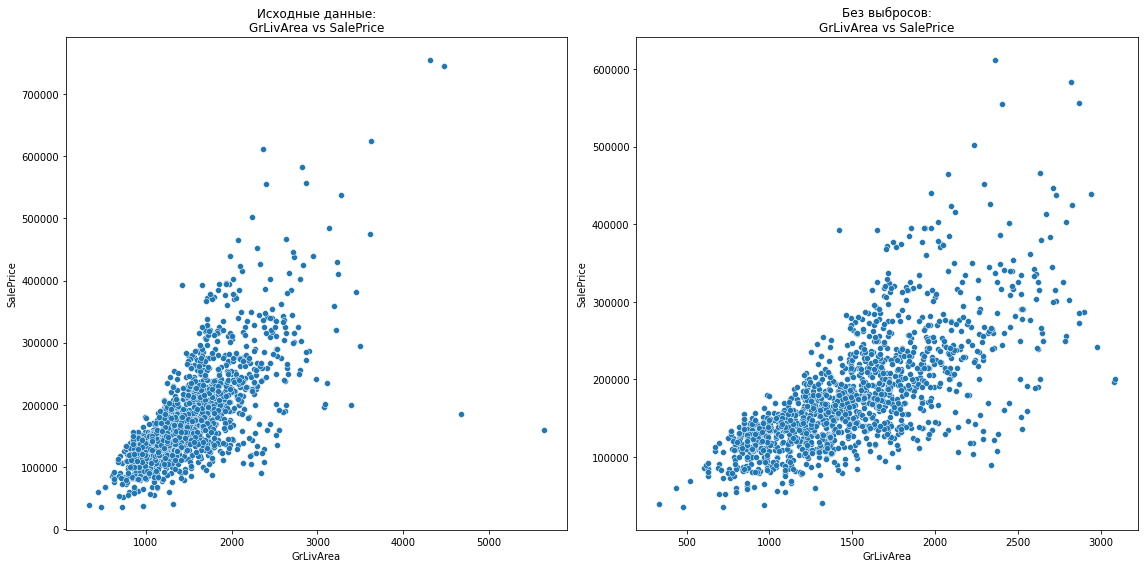

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
sns.scatterplot(x=train['GrLivArea'], y=train['SalePrice'])
plt.title('Исходные данные:\nGrLivArea vs SalePrice')

plt.subplot(1, 2, 2)
sns.scatterplot(x=train[train.z_score < 3]['GrLivArea'], y=train['SalePrice'])
plt.title('Без выбросов:\nGrLivArea vs SalePrice')
plt.tight_layout()

In [19]:
train = train[train.z_score < 3]
train.drop(columns='z_score', inplace=True)

### 2. Посмотрим наличие пропущенных значений

In [20]:
train.isnull().sum()

MSSubClass         0
MSZoning           0
LotFrontage      257
LotArea            0
Street             0
                ... 
MoSold             0
YrSold             0
SaleType           0
SaleCondition      0
SalePrice          0
Length: 80, dtype: int64

Колонок слишком много, можем обернуть результат в словарь и отсортировать по количеству пропусков по убыванию. 

In [21]:
sorted(dict(train.isnull().sum()).items(), key=lambda x: x[1], reverse=True)[:20]

[('PoolQC', 1440),
 ('MiscFeature', 1390),
 ('Alley', 1354),
 ('Fence', 1167),
 ('FireplaceQu', 689),
 ('LotFrontage', 257),
 ('GarageType', 80),
 ('GarageYrBlt', 80),
 ('GarageFinish', 80),
 ('GarageQual', 80),
 ('GarageCond', 80),
 ('BsmtExposure', 38),
 ('BsmtFinType2', 38),
 ('BsmtQual', 37),
 ('BsmtCond', 37),
 ('BsmtFinType1', 37),
 ('MasVnrType', 8),
 ('MasVnrArea', 8),
 ('Electrical', 1),
 ('MSSubClass', 0)]

Взглянем на описание данных из документации, где рекомендованы разные стратегии по заполнению пропущенных значений:

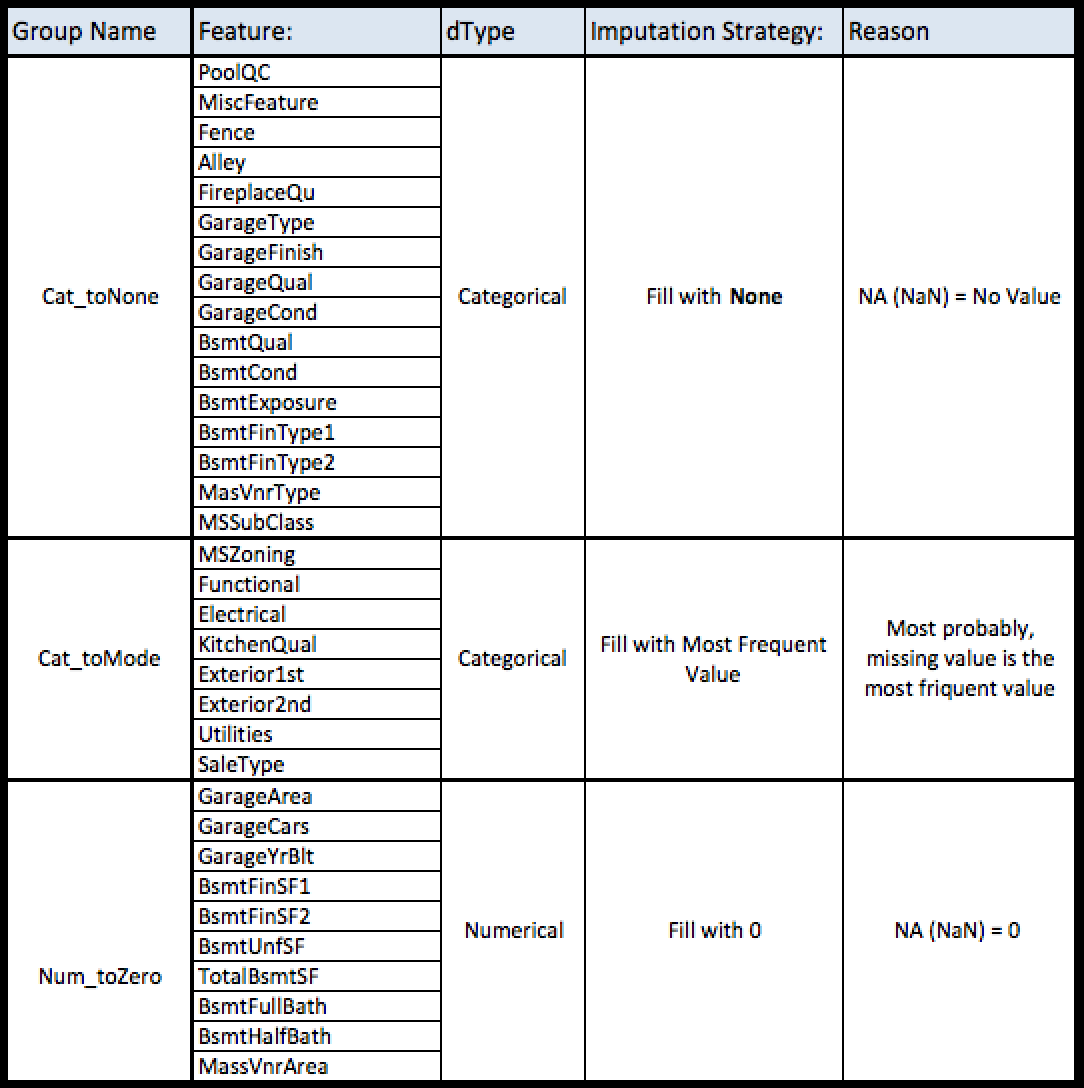

In [22]:
from IPython.display import Image
Image("./data/data_desc.png", height=800 , width=600)

Заполним пропущенные значения в соответствии со стратегиями выше:

In [23]:
cat_to_none = ('PoolQC', 'MiscFeature', 'Fence', 'Alley', 'FireplaceQu', 'GarageType', 'GarageFinish',
              'GarageQual', 'GarageCond', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1',
              'BsmtFinType2', 'MasVnrType', 'MSSubClass')
    
cat_to_mode = ('MSZoning', 'Functional', 'Electrical', 'KitchenQual', 'Exterior1st', 'Exterior2nd',
              'Utilities', 'SaleType')

num_to_zero = ('GarageArea', 'GarageCars', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF',
              'BsmtFullBath', 'BsmtHalfBath', 'GarageYrBlt', 'MasVnrArea')

for col in cat_to_none:
    train[col] = train[col].fillna('None')

for col in cat_to_mode:
    train[col] = train[col].fillna(train[col].mode()[0])
    
for col in num_to_zero:
    train[col] = train[col].fillna(0)


* По переменной **LotFrontage** нужен дополнительный анализ

Поскольку LotFrontage - это расстояние до двора дома, мы можем сделать предположение, что оно зависит от района, в котором расположен дом. Таким образом, мы можем сгруппировать значения LotFrontage по признаку соседства и заменить отсутствующие значения на медианное расстояние LotFrontage по соседству.

In [24]:
train["LotFrontage"] = train.groupby("Neighborhood")["LotFrontage"].transform(lambda x: x.fillna(x.median()))

### 3. Добавим фичи

![](https://i.pinimg.com/originals/80/b2/fe/80b2febe7af2b92dd3e8565110d507e7.jpg)

Для примера:
* Пусть Total_SF будет общий метраж дома.

In [25]:
train['Total_SF'] = (train['1stFlrSF'] + train['2ndFlrSF'] + 
                       + train['TotalBsmtSF'] + train['GarageArea'] + 
                       + train['GrLivArea'] + train['PoolArea'] + train['WoodDeckSF'])

Вот Вы написали уже свою первую "фичу", как настоящий машинлернер.

P.S.: Осталось только выучить машинное обучение, чтобы понять, что в линейной регрессии данная фича не имеет пользы.

In [26]:
# HUGE tonn of features can be written here

И еще: нужно сделать дамми переменные (см. прошлый семинар), потому что у нас куча категориальных признаков.

In [27]:
train = pd.get_dummies(train)

## Ridge и Lasso


Начнем с обучения простой регрессии. Копипастнем код с прошлого датасета.

In [28]:
train_data, test_data = train_test_split(train, test_size=0.5, random_state=67)

from sklearn.linear_model import ElasticNet, Lasso, Ridge, RidgeCV, LassoCV

X_train, Y_train = get_features_and_taget(train_data, "SalePrice")
X_test, Y_test = get_features_and_taget(test_data, "SalePrice")

model = LinearRegression()
model.fit(X_train, Y_train)


Y_train_prediced = model.predict(X_train)
Y_test_prediced = model.predict(X_test)

print("Train R-squared Correlation", r2_score(Y_train_prediced, Y_train))
print("Test R-squared Correlation", r2_score(Y_test_prediced, Y_test))

Train R-squared Correlation 0.9554338949809922
Test R-squared Correlation 0.8601855352467428


А теперь давайте подумаем. **Что, если у нас и так уже есть переобучение?**

Можем ли мы как-то избежать его? Какие есть варианты? Есть ли общий подход? Есть!


Обозначения:

* $X$ - входные переменные (признаки)
* $w$ - вектор весов. В простом однофакторном линейном уравнении это был наш коэффициент наклона. Мы пытаемся оценить наш вектор весов $w$ с помощью регрессии.
* $y$ - значение целевой переменной. Оно равно скалярному произведению $w\cdot X$. Оценка целевой переменной обозначается как $\hat y$ 
* $\lambda$ - гиперпараметр, определяющий силу штрафа.

Чтобы повысить точность и обобщающую способность наших моделей, мы будем использовать регуляризацию (L1 или L2) в нашем уравнении регрессии. Регуляризация позволяет увеличить смещение и снизить разброс модели за счет увеличения значения штрафа - гиперпараметра $\lambda$. 

* **Ridge (гребневая) регрессия:**

Модель с штрафом L2, где к функции потерь МНК добавляется сумма весов в квадрате. При увеличении гиперпараметра $\lambda$б гребневая регрессия добавляет в модель больше смещения, поэтому качество обучения на train будет не лучшим, но при этом постепенно достигается сокращение переобучения на тестовых данных. Гребневая регрессия минимизирует (за счет штрафа) вес нерелевантных признаков, но не зануляет их. Эта модель применяется для борьбы с избыточностью данных, когда независимые переменные коррелируют друг с другом, вследствие чего проявляется неустойчивость оценок коэффициентов многомерной линейной регрессии.

$\sum_{i=1}^{n}(y_i - \hat y_i)^2 + \lambda||w||^2$

* **Lasso регрессия**:

Модель со штрафом L1, где вместо квадратов в штрафе мы используем модуль. Сила регуляризации также увеличивается с увеличением $\lambda$, однако Lasso, в результате, отбирает признаки, поскольку зануляет веса при нерелевантных. 

$\sum_{i=1}^{n}(y_i - \hat y_i)^2 + \lambda||w||$

* **Регрессия ElasticNet**: 

Это модель со штрафами $L2 + L1$, где  к функции потерь добавлены оба параметра регуляризации. Эта модель была введена для ограничения иногда неточного отбора признаков Lasso, когда релевантные признаки обнуляются. Добавление штрафа $L2$ в модель увеличивает шансы на сохранение важных признаков. Обычно в определении ElasticNet необходимо указывать соотношение $\frac{L1}{L2}$, но чаще всего берут отношение $0.5$.

$\sum_{i=1}^{n}(y_i - \hat y_i)^2 + \lambda_{1}||w||^2 + \lambda_{2}||w||$



Давайте заиспользуем же готовые модули! Но, **тут важно приводить все признаки к одному масштабу**

In [35]:
from sklearn.linear_model import ElasticNet, Lasso, Ridge
from sklearn.preprocessing import StandardScaler

train_data, test_data = train_test_split(train, test_size=0.5, random_state=67)

X_train, Y_train = get_features_and_taget(train_data, "SalePrice")
X_test, Y_test = get_features_and_taget(test_data, "SalePrice")

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

model = Lasso(alpha=20.0) # just change me to any other model
model.fit(X_train, Y_train)


Y_train_predicted = model.predict(X_train)
Y_test_predicted = model.predict(X_test)

print("Train R-squared Correlation", r2_score(Y_train_predicted, Y_train))
print("Test R-squared Correlation", r2_score(Y_test_predicted, Y_test))

Train R-squared Correlation 0.9549017510633891
Test R-squared Correlation 0.8683273779402451


Стало лучше, а давайте подберем оптимальный параметр альфы!

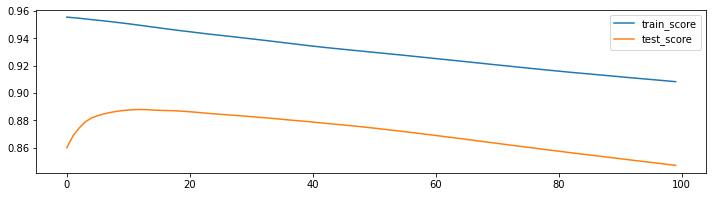

In [36]:
runs = []

from tqdm import tqdm_notebook

for alpha in tqdm_notebook(np.linspace(1, 2000, 100)):

    model = Lasso(alpha=alpha) # change me between Ridge and Lasso
    model.fit(X_train, Y_train)

    Y_train_prediced = model.predict(X_train)
    Y_test_prediced = model.predict(X_test)

#     print("Alpha", alpha)
#     print("Train R-squared Correlation", r2_score(Y_train_prediced, Y_train))
#     print("Test R-squared Correlation", r2_score(Y_test_prediced, Y_test))
    
    runs.append({
        "coef": model.coef_,
        "train_score": r2_score(Y_train_prediced, Y_train),
        "test_score": r2_score(Y_test_prediced, Y_test),
    })
    
    
plt.figure(figsize=(12,3))
plt.plot([run["train_score"] for run in runs], label="train_score")
plt.plot([run["test_score"] for run in runs], label="test_score")
plt.legend()
plt.show()


Теперь посмотрим, как меняются коэффициенты при разных уровнях альфы, для ридж и для лассо:

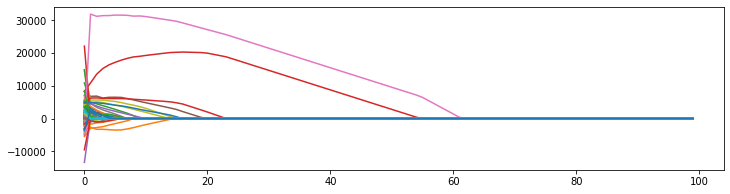

In [37]:
runs = []

from tqdm import tqdm_notebook

for alpha in tqdm_notebook(np.linspace(1, 100000, 100)):

    model = Lasso(alpha=alpha) # change me between Ridge and Lasso
    model.fit(X_train, Y_train)

    Y_train_prediced = model.predict(X_train)
    Y_test_prediced = model.predict(X_test)

#     print("Alpha", alpha)
#     print("Train R-squared Correlation", r2_score(Y_train_prediced, Y_train))
#     print("Test R-squared Correlation", r2_score(Y_test_prediced, Y_test))
    
    runs.append({
        "coef": model.coef_,
        "train_score": r2_score(Y_train_prediced, Y_train),
        "test_score": r2_score(Y_test_prediced, Y_test),
    })


plt.figure(figsize=(12,3))
plt.plot(np.array([run["coef"] for run in runs]))
plt.show()

Материал для отличников: (optional)

Почему так? Это не случайно!

![](https://miro.medium.com/max/761/1*nrWncnoJ4V_BkzEf1pd4MA.png)

### Еще немного визуализации

Давайте постоим график лассо или ридж регрессии, с один предиктором

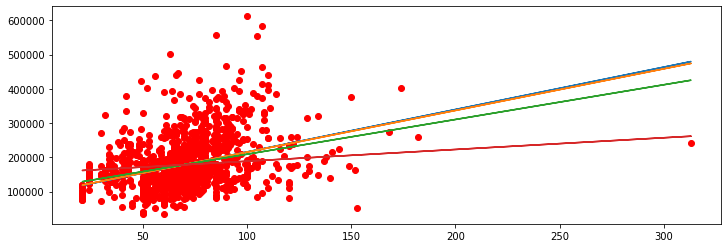

In [38]:
FEATURE_INDEX = 1

X, Y = get_features_and_taget(train, "SalePrice")

X = X[:, [FEATURE_INDEX]]

plt.figure(figsize=(12, 4))
plt.scatter(X, Y, color = "red")
for alpha in [0.1, 10000, 100000, 400000]: 
    model = Lasso(alpha=alpha)
    model.fit(X, Y)
    plt.plot(X, model.predict(X))

plt.show()


## 3. Кросс-валидация
 
 
Предположим, мы подобрали оптимальный параметр. **А чтоб если мы бы разбили выборку по-другому?** Получился бы у нас другой оптимальный параметр? А давайте разобьем по-разному и подберем оптимальный параметр в среднем!

**Кросс-валидация** (или скользящий контроль) — это процедура оценивания обобщающей способности модели, она бывает нескольких видов. Валидация на отложенных данных (**Hold-Out Validation**) - это когда мы один раз случайным образом делим выборку на train и test. 
Сегодня мы попробуем другой вид - **k-fold кросс-валидация**. 

1. Обучающая выборка разбивается на k непересекающихся одинаковых по объему частей;<br>
2. Производится k итераций. На каждой итерации происходит следующее: <br>
    2.1 Модель обучается на k−1 части обучающей выборки; <br>
    2.2 Модель тестируется на части обучающей выборки, которая не участвовала в обучении.<br>

Каждая из k частей единожды используется для тестирования. Как правило, k=10 (5 в случае малого размера выборки).

![](https://long-short.pro/wp-content/uploads/sites/3/2013/06/crossvalidation.png)

In [39]:
from sklearn.model_selection import cross_validate

model = Lasso(alpha=1)
cv_results = cross_validate(model, X_train, Y_train, cv=4)
cv_results

{'fit_time': array([0.09464383, 0.06869411, 0.06608891, 0.06569409]),
 'score_time': array([0.00058293, 0.00053191, 0.00051713, 0.00052094]),
 'test_score': array([0.85386265, 0.84527892, 0.91011815, 0.8219018 ])}

In [40]:
runs = []

from tqdm import tqdm_notebook

X, Y = get_features_and_taget(train, "SalePrice")

for alpha in tqdm_notebook(np.linspace(0, 2000, 25)):

    model = Lasso(alpha=alpha) # change me between Ridge and Lasso
    cv_results = cross_validate(model, X, Y, cv=4)

    print("Alpha", alpha)
    print("Test Score", cv_results['test_score'].mean())


Alpha 0.0
Test Score 0.8953338068993264
Alpha 83.33333333333333
Test Score 0.9101569173998088
Alpha 166.66666666666666
Test Score 0.9092364732792819
Alpha 250.0
Test Score 0.9057602763495584
Alpha 333.3333333333333
Test Score 0.9008716817545261
Alpha 416.66666666666663
Test Score 0.8964012077912373
Alpha 500.0
Test Score 0.8931301957898917
Alpha 583.3333333333333
Test Score 0.8904694030151717
Alpha 666.6666666666666
Test Score 0.8880187463407024
Alpha 750.0
Test Score 0.8854794217154045
Alpha 833.3333333333333
Test Score 0.8832643710220168
Alpha 916.6666666666666
Test Score 0.8810925224001604
Alpha 1000.0
Test Score 0.8790458133206798
Alpha 1083.3333333333333
Test Score 0.8769995253013961
Alpha 1166.6666666666665
Test Score 0.875061101584002
Alpha 1250.0
Test Score 0.8732061839350032
Alpha 1333.3333333333333
Test Score 0.8713277250211066
Alpha 1416.6666666666665
Test Score 0.8693153490226846
Alpha 1500.0
Test Score 0.8672260198832198
Alpha 1583.3333333333333
Test Score 0.86508086136572

# 3. Рекомендуем посмотреть <a name=recoms>
    
1. [Kaggle. Ridge,Lasso, ElasticNet Regressions Explained](https://www.kaggle.com/fugacity/ridge-lasso-elasticnet-regressions-explained)
2. [Анализ малых данных (блог А.Дьяконова). Разброс и смещение](https://dyakonov.org/2018/04/25/%D1%81%D0%BC%D0%B5%D1%89%D0%B5%D0%BD%D0%B8%D0%B5-bias-%D0%B8-%D1%80%D0%B0%D0%B7%D0%B1%D1%80%D0%BE%D1%81-variance-%D0%BC%D0%BE%D0%B4%D0%B5%D0%BB%D0%B8-%D0%B0%D0%BB%D0%B3%D0%BE%D1%80%D0%B8%D1%82/)

Youtube видео с визуализациями:

* [Ridge Regression](https://www.youtube.com/watch?v=Q81RR3yKn30)

* [Lasso Regression](https://www.youtube.com/watch?v=NGf0voTMlcs)

* [Ridge vs Lasso Regression visualized](https://www.youtube.com/watch?v=Xm2C_gTAl8c&ab_channel=StatQuestwithJoshStarmer)